# Visual SAHap

[![badge](https://img.shields.io/badge/open%20in-binder-579ACA.svg?logo=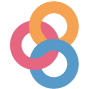)](https://gke.mybinder.org/v2/gh/zhaofengli/SAHap/master?urlpath=%2Flab%2Ftree%2Fvisual-sahap.ipynb)

This Jupyter notebook demonstrates the ability to use SAHap interactively with the [xeus-cling](https://github.com/QuantStack/xeus-cling) C++ kernel. It enables easy visualization of the simulated annealing process, as well as a faster iterative parameter tuning workflow.

The library [matplotlib-cpp](https://github.com/lava/matplotlib-cpp) is used for plotting, and you may need to adjust the paths for your system.

This notebook is still a work-in-progress.

## Preparation

The following cell builds SAHap, which provides a shared library `libsahap.so`:

In [ ]:
!meson build; ninja -C build/; git clone --depth=1 https://github.com/lava/matplotlib-cpp

## Preamble

You may need to adjust the paths below:

In [2]:
#pragma cling add_include_path("/opt/conda/include/python3.7m")
#pragma cling add_include_path("/opt/conda/lib/python3.7/site-packages/numpy/core/include")
#pragma cling add_library_path("/opt/conda/lib")
#pragma cling add_include_path("/srv/conda/envs/notebook/include/python3.7m")
#pragma cling add_include_path("/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/include")
#pragma cling add_library_path("/srv/conda/envs/notebook/lib")
#pragma cling load("python3.7m")

In [3]:
#pragma cling add_include_path("include")
#pragma cling add_library_path("build/src")
#pragma cling load("libsahap")

In [4]:
#include <iostream>
#include <fstream>
#include <vector>
#include "matplotlib-cpp/matplotlibcpp.h"
#include "xcpp/xdisplay.hpp"
#include "Genome.hpp"

namespace plt = matplotlibcpp;

In [5]:
// Credits:
// - https://github.com/QuantStack/xeus-cling/issues/255#issuecomment-513541199
// - https://xeus-cling.readthedocs.io/en/latest/rich_display.html

#include "xtl/xbase64.hpp"
#include "xeus/xjson.hpp"

namespace im {
    struct image {   
        inline image(const std::string& filename) {
            std::ifstream fin(filename, std::ios::binary);   
            m_buffer << fin.rdbuf();
        }
        
        std::stringstream m_buffer;
    };
    
    xeus::xjson mime_bundle_repr(const image& i) {
        auto bundle = xeus::xjson::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer.str());
        return bundle;
    }
}

## Finding $p_{\text{bad}}$

In [6]:
ifstream file("data/2-1000/reads", ifstream::in);
SAHap::Genome ge(file, 1000, 2);

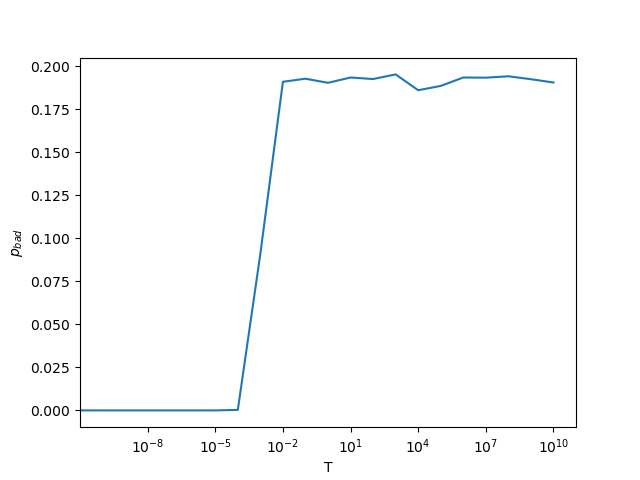

In [7]:
{
matplotlibcpp::close();
vector<float> x(21), y(21);
    
x.reserve(21);
y.reserve(21);

for (float e = -10; e <= 10; ++e) {
    xcpp::clear_output();
    float temp = pow(10, e);
    cout << "Computing " << temp << endl;
    x.push_back(temp);
    y.push_back(ge.findPbad(temp));
}

xcpp::clear_output();
matplotlibcpp::xlabel("T");
matplotlibcpp::ylabel("$p_{bad}$");
matplotlibcpp::semilogx(x, y);
matplotlibcpp::save("./pbad.png");
}

xcpp::display(im::image("./pbad.png"));

## Stochastic hill-climbing

Let's perform a simple test where we perform 100,000 iterations, and only accept moves that decrease our loss (MEC). The following cell will be run 7 times to produce the average run time of the procedure.

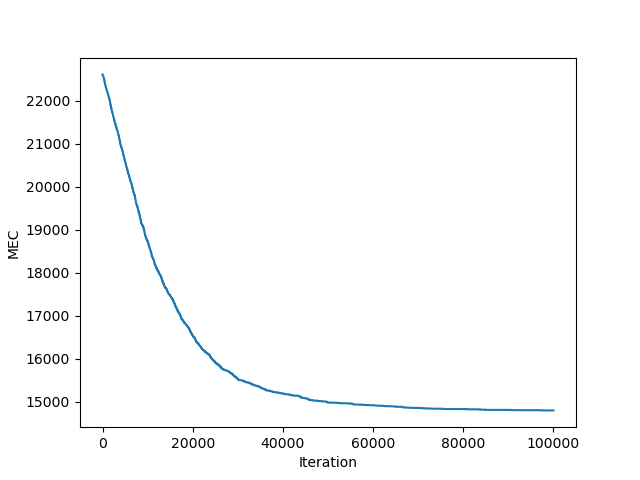

2.78 s +- 212 ms per loop (mean +- std. dev. of 7 runs 1 loop each)


In [8]:
%%timeit

{
constexpr int ITER = 100000;

ge.shuffle();
matplotlibcpp::close();

vector<float> x, y;
x.reserve(ITER);
y.reserve(ITER);
    
auto mec = ge.mec();

for (int i = 0; i < ITER; ++i) {
    if (i % 1000 == 0) {
        xcpp::clear_output();
        cout << i + 1 << "/" << ITER << endl;
    }

    ge.move();
    auto newMec = ge.mec();
    
    if (newMec > mec) {
        ge.revertMove();
    } else {
        mec = newMec;
    }
    x.push_back(i);
    y.push_back(mec);
}

xcpp::clear_output();
plt::xlabel("Iteration");
plt::ylabel("MEC");
plt::plot(x, y);
plt::save("./hill-climbing.png");
}

xcpp::display(im::image("./hill-climbing.png"));

In [9]:
ge.mec()

14802